In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Vehicle Detection

In [45]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pdb
from pathlib import Path
from moviepy.editor import VideoFileClip
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [19]:
PATH = Path('./data/')
vehicles = PATH/'vehicles'
list(vehicles.iterdir())[:5]

[WindowsPath('data/vehicles/GTI_Far'),
 WindowsPath('data/vehicles/GTI_Left'),
 WindowsPath('data/vehicles/GTI_MiddleClose'),
 WindowsPath('data/vehicles/GTI_Right'),
 WindowsPath('data/vehicles/KITTI_extracted')]

In [20]:
GTI_Far = vehicles/'GTI_Far'
list(GTI_Far.iterdir())[:5]

[WindowsPath('data/vehicles/GTI_Far/image0000.png'),
 WindowsPath('data/vehicles/GTI_Far/image0001.png'),
 WindowsPath('data/vehicles/GTI_Far/image0002.png'),
 WindowsPath('data/vehicles/GTI_Far/image0003.png'),
 WindowsPath('data/vehicles/GTI_Far/image0004.png')]

In [26]:
def get_hog_features(img, orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True):
    hog_features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec,
                          block_norm="L2-Hys")
    
    if vis: plt.imshow(hog_image)
    return hog_features

In [29]:
filename = str(list(GTI_Far.iterdir())[0])
img = cv2.imread(filename)
print(img.shape)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)

(64, 64, 3)
(64, 64)


array([0.01266656, 0.01449117, 0.00387425, ..., 0.00034923, 0.00059008,
       0.00018907])

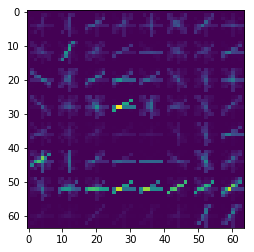

In [30]:
get_hog_features(gray, vis=True)

In [32]:
def bin_spatial(img, cspace='RGB', size=(24, 24)):
    # Convert image to new color space (if specified)

    # Use cv2.resize().ravel() to create the feature vector
    vector = cv2.resize(img, size)
    # Return the feature vector
    return vector

In [38]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [40]:
def extract_features(imgs, cspace='RGB', spatial_size=(24, 24),
                        hist_bins=32, hist_range=(0, 256)):
    features = []
    for img in imgs:
        # apply color conversion if other than 'RGB'
        if cspace == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        if cspace == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        bins = bin_spatial(img, spatial_size)
        hist = color_hist(img, hist_bins, hist_range)
        vec = np.concatenate((bins,hist))
        features.append(vec)
    return features

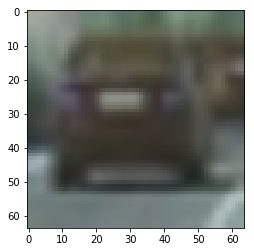

In [41]:
plt.imshow(img)
# print(bin_spatial(img, color_space='HSV'))

For each image, features can be extracted: in this case, HOG and colorspace data. That can then be normalized and passed into a classifier. 

The training and test sets must be randomized.

Support Vector Machines work well with HOG features.

# Let's normalize the features

In [ ]:
car_features = extract_features(...)
notcar_features = extract_features(...)

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]} # What params to try
svr = svm.SVC() # What alg to use
clf = grid_search.GridSearchCV(svr, parameters) # Create a classifier
clf.fit(iris.data, iris.target) # Test all params against an accuracy fxn

y = np.hstack((np.ones(len(car_features)), # 1 = Car
               np.zeros(len(notcar_features)))) # 0 = Not Car

X = np.vstack((car_features, notcar_features)).astype(np.float64)


rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
X_scaler = StandardScaler().fit(X_train) # Only fit on training data!
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)
